In [33]:
import altair as alt
from vega_datasets import data
import pandas as pd
import requests
import geopandas as gpd
import json

In [34]:
# Wrangling 
world_map = alt.topo_feature(data.world_110m.url, 'countries')
earthquake_data = pd.read_csv('../data/earthquake_data.csv')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.continent!='Antarctica']
world = world[['iso_a3', 'geometry']]
world = world.rename(columns={"iso_a3":"Code"})
world = world.merge(earthquake_data, how='inner', on='Code')
earthquake_data  = alt.InlineData(values = world.to_json(),
                       format = alt.DataFormat(property='features',type='json')) 

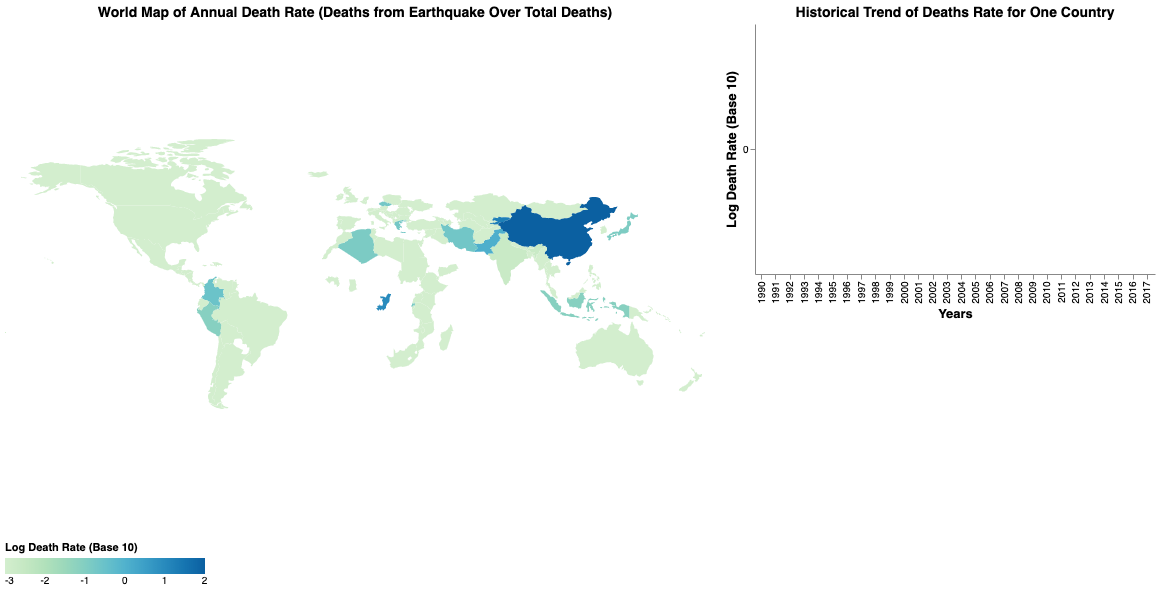

In [57]:
# Plotting
# Add clicking for countries
click = alt.selection_single(fields=['properties.Country'], empty='none')

# Add slider for years 
slider = alt.binding_range(min=1990, max=2017, step=1)
slider_bar = alt.selection_single(
    fields=['properties.Year'], bind=slider, name='Select', init={'properties.Year': 2008})

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['properties.Year'], empty='none')

color_condition = alt.condition(click,
                                alt.value('salmon'),
                                alt.Color('properties.log_Death_rate:Q', 
                                          legend=alt.Legend(orient='bottom',
                                                            title='Log Death Rate (Base 10)'),
                                          scale=alt.Scale(scheme='greenblue')))

# Map
world_map = alt.Chart(earthquake_data).mark_geoshape().encode(
    color=color_condition,
    tooltip=[alt.Tooltip('properties.Country:N', title='Country'),
             alt.Tooltip('properties.Death_earthquake:Q', title='Number of Deaths')]
).properties(
    projection={"type": 'equirectangular'},
    width=700,
    height=500,
    title="World Map of Annual Death Rate (Deaths from Earthquake Over Total Deaths)"
).add_selection(
    click,
    slider_bar
).transform_filter(
    slider_bar
)

# Line chart
death_rate_baseline = alt.Chart().mark_line().encode(
    alt.X('properties.Year:O', title="Years"),
    alt.Y('properties.log_Death_rate:Q', title="Log Death Rate (Base 10)")
).transform_filter(
    click
).properties(
    width=400,
    height=250,
    title='Historical Trend of Deaths Rate for One Country'
)

# Add selectors
selectors = alt.Chart().mark_point().encode(
    x='properties.Year:O',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Add points
points = death_rate_baseline.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Add text
text = death_rate_baseline.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'properties.log_Death_rate:Q', alt.value(' '), format='.2f')
)

# Add rules
rules = alt.Chart().mark_rule(color='lightgray').encode(
    x='properties.Year:O',
).transform_filter(
    nearest
)

death_rate = alt.layer(
    death_rate_baseline, selectors, points, rules, text,
    data=earthquake_data
)

alt.hconcat(
    world_map,
    death_rate
).configure_axis(
    labelFontSize=10,
    titleFontSize=13,
    grid=False
).configure_title(
    fontSize=14
).configure_view(
    strokeWidth=0
)

In [58]:
world_map_line = alt.hconcat(
    world_map,
    death_rate
).configure_axis(
    labelFontSize=10,
    titleFontSize=13,
    grid=False
).configure_title(
    fontSize=14
).configure_view(
    strokeWidth=0
)
world_map_line.save('world_map_line.html')